# Amazon SageMaker LightGBM Distributed training using Dask

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

---

---
Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

This notebook demonstrates the use of distributed training for Amazon SageMaker’s implementation of the [LightGBM](https://lightgbm.readthedocs.io/en/latest/) with Dask.

In this notebook, we demonstrate two use cases:

* How to distributedly train a tabular model using Dask on the customer churn dataset.
* How to use the trained tabular model to perform inference, i.e., classifying new samples.


Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

---

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.

---

In [ ]:
!pip install sagemaker ipywidgets --upgrade

In [ ]:
! pip install s3fs --upgrade


---
To train and host on Amazon SageMaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3.

---

In [2]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-churn-dt-regression"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sklearn import preprocessing

## 2. Data Preparation and Visualization

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes. After all, predicting the future is tricky business! But we’ll learn how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let’s download and read that dataset in now:

In [9]:
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{aws_region}",
    "datasets/tabular/synthetic/churn.txt",
    "churn.txt",
)

In [17]:
churn = pd.read_csv("./churn.txt")
pd.set_option("display.max_columns", 500)
# Convert dataset to regression type
churn['target'] = np.random.randint(0, 100, size=len(churn))
# Drop Binary Label
churn.drop(["Churn?"], axis=1, inplace=True)
churn.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,target
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,95
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,4
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,89
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,62
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,41


In [18]:
# To increase the size of the table for the purpose of increasing the training data size
# churn = pd.concat([churn]*50, ignore_index=True)

In [19]:
print(churn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   object 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   int64  
 3   Phone           5000 non-null   object 
 4   Int'l Plan      5000 non-null   object 
 5   VMail Plan      5000 non-null   object 
 6   VMail Message   5000 non-null   int64  
 7   Day Mins        5000 non-null   float64
 8   Day Calls       5000 non-null   int64  
 9   Day Charge      5000 non-null   float64
 10  Eve Mins        5000 non-null   float64
 11  Eve Calls       5000 non-null   int64  
 12  Eve Charge      5000 non-null   float64
 13  Night Mins      5000 non-null   float64
 14  Night Calls     5000 non-null   int64  
 15  Night Charge    5000 non-null   float64
 16  Intl Mins       5000 non-null   float64
 17  Intl Calls      5000 non-null   i

In [ ]:
# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that: - `State` appears to be quite evenly distributed. - `Phone` takes on too many unique values to be of any practical use. It’s possible that parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it. - Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. `VMail Message` is a notable exception.

In [20]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

In [21]:
churn = churn[["target"] + churn.columns.tolist()[:-1]]

We identify the column indexes of the categorical attribute, which is required by LightGBM, CatBoost, and TabTransformer algorithm (AutoGluon-Tabular has built-in feature engineering to identify the categorical attribute automatically, and thus does not require such input).

In [22]:
cat_columns = [
    "State",
    "Account Length",
    "Area Code",
    "Phone",
    "Int'l Plan",
    "VMail Plan",
    "VMail Message",
    "Day Calls",
    "Eve Calls",
    "Night Calls",
    "Intl Calls",
    "CustServ Calls",
]

cat_idx = []
for idx, col_name in enumerate(churn.columns.tolist()):
    if col_name in cat_columns:
        cat_idx.append(idx)

In [24]:
with open("cat_idx.json", "w") as outfile:
    json.dump({"cat_idx": cat_idx}, outfile)

[LightGBM official documentation](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support) requires that all categorical features should be encoded as non-negative integers. 

In [25]:
for idx, col_name in enumerate(churn.columns.tolist()):
    if col_name in cat_columns:
        le = preprocessing.LabelEncoder()
        churn[col_name] = le.fit_transform(churn[col_name])

In [26]:
churn

,target,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,95,38,162,22,0,1,3,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,2,5.111624,4.928160,6,5.673203,3
1,4,40,14,24,1,0,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,4,6.436188,3.221748,6,2.559749,8
2,89,24,130,15,0,1,3,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,2,5.142451,7.139023,2,6.254157,4
3,62,50,74,32,1,1,7,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,9,3.814413,2.245779,6,1.080692,6
4,41,50,145,32,1,0,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,5,2.796812,6.905545,4,7.134343,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,30,3,18,1,1,8,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,7,6.748489,4.872570,8,2.122530,9
4996,42,41,139,24,0,0,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,6,4.522661,6.938571,2,4.600473,4
4997,96,40,31,24,0,1,7,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,9,5.157898,4.388328,7,1.060340,6
4998,35,19,141,14,1,1,6,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,3,4.362780,7.173376,3,4.871900,7


We split the churn dataset into train, validation, and test set using stratified sampling. Validation set is used for early stopping and AMT. Test set is used for performance evaluations in the end. Next, we upload them into a S3 path for training.

The structure of the S3 path for training should be structured as below.

* The supported input data format for training is `csv`. You are allowed to put more than 1 data file under both train and valdiation channel. The name of data file can be any one as long as it ends with `.csv`.
* The first column corresponds to the target and the rest of columns correspond to features. This follows the convention of [SageMaker XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html). 
* The `cat_idx.json` is categorical column indexes. It contains a dictionary of a key-value pair. The key can be any string. The value is the list of column indexes of categorical features. The index starts with value 1 as value 0 corresponds to the target variable. Please see example above to format the `cat_idx.json`.
* For the validation data, we encourage you to include one data file under its channel such that the all of the validation data points can be assigned to one machine. Thus, the validation score is for all of the validation data points and can be easily parsed by the AMT for hyperparameter optimization.
* Current distributed training only supports CPU.

-- `train`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data_1.csv`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data_2.csv`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data_3.csv`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `cat_idx.json`
    
-- `validation`<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-- `data.csv`    


In [27]:
from sklearn.model_selection import train_test_split

train, val_n_test = train_test_split(
    churn, test_size=0.3, random_state=42, stratify=churn["target"]
)

In [28]:
val, test = train_test_split(
    val_n_test, test_size=0.3, random_state=42, stratify=val_n_test["target"]
)

In [29]:
train.to_csv("train.csv", header=False, index=False)
val.to_csv("validation.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

For demonstartion purpose on including multiple files under the training channel, we simply duplicate the training data multiple times as shown below. However, this is not mandatory and you can use just a single file for training

In [30]:
from tqdm import tqdm

for i in tqdm(range(200)):
    boto3.Session().resource("s3").Bucket(bucket).Object(
        os.path.join(prefix, f"train_set/data_{i}.csv")
    ).upload_file("train.csv")

100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


In [31]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation_set/data.csv")
).upload_file("validation.csv")

In [32]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "test_set/data.csv")
).upload_file("test.csv")

In [33]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train_set/cat_idx.json")
).upload_file("cat_idx.json")

## 3. Distributedly Train A SageMaker LightGBM Model with AMT

### 3.1. Retrieve Training Artifacts

___

Here, we retrieve the training docker container, the training algorithm source, and the tabular algorithm. Note that model_version="*" fetches the latest model.

For the training algorithm, we have four choices in this demonstration for classification task.
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/): To use this algorithm, specify `train_model_id` as `lightgbm-classification-model` in the cell below.

For regression task, the `train_model_id` is `lightgbm-regression-model`.


---

In [34]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"
training_instance_type = "ml.m5.2xlarge" 

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'lightgbm-regression-model' with wildcard version identifier '*'. You can pin to version '2.1.3' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


### 3.2. Set Training Parameters

---

Now that we are done with all the setup that is needed, we are ready to train our tabular algorithm. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training.

The second set of parameters are algorithm specific training hyper-parameters. 

---

In [35]:
training_dataset_s3_path = f"s3://{bucket}/{prefix}/train_set/"
validation_dataset_s3_path = f"s3://{bucket}/{prefix}/validation_set/"

output_prefix = "jumpstart-example-tabular-training"
s3_output_location = f"s3://{bucket}/{output_prefix}/output_lgb"
training_dataset_s3_path, validation_dataset_s3_path

('s3://sagemaker-us-east-1-715253196401/sagemaker/DEMO-churn-dt-regression/train_set/',
 's3://sagemaker-us-east-1-715253196401/sagemaker/DEMO-churn-dt-regression/validation_set/')

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values. For the evaluation metric that is used by early stopping and automatic model tuning, we choose `auc` score. Note. LightGBM does not have built-in F1 score supported. See [LightGBM documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters).

---

In [43]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["num_boost_round"] = "200"
hyperparameters["metric"] = "rmse"

print(hyperparameters)

{'num_boost_round': '200', 'early_stopping_rounds': '30', 'metric': 'rmse', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'tweedie_variance_power': '1.5', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


### 3.3. Train with Automatic Model Tuning  


Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a HyperparameterTuner object to interact with Amazon SageMaker hyperparameter tuning APIs.

* Note. In this notebook, we set AMT budget (total tuning jobs) as 10 for each of the tabular algorithm except AutoGluon-Tabular. For [AutoGluon-Tabular](https://arxiv.org/abs/2003.06505), it succeeds by ensembling multiple models and stacking them in multiple layers.  

In [44]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner
#Enable HyperParameterTuning
use_amt = True
# Define hyperparameter ranges
hyperparameter_ranges_lgb = {
    "learning_rate": ContinuousParameter(1e-4, 1, scaling_type="Logarithmic"),
    "num_boost_round": IntegerParameter(2, 30),
    "num_leaves": IntegerParameter(10, 50),
    "feature_fraction": ContinuousParameter(0.1, 1),
    "bagging_fraction": ContinuousParameter(0.1, 1),
    "bagging_freq": IntegerParameter(1, 10),
    "max_depth": IntegerParameter(5, 30),
    "min_data_in_leaf": IntegerParameter(5, 50),
}

### 3.4. Start Training

---
We start by creating the estimator object with all the required assets and then launch the training job. 

* To enable distributed training, you only need specify the number of instances to be more than 1.
* You might need increase the argument volumn_size if your dataset size is larger than the default value (30GB). Otherwise, you may see insufficient disk memory error.

SageMaker Training Directory Setup for Script Mode:

- Create a root project directory.
- Place main training script (e.g., train.py) in root.
- Add other Python modules/scripts to root or subdirectories.
- Include requirements.txt for dependencies. Sagemaker automatically installs all libs listed in this text file

Example structure:
```
project/
    ├── train.py
    ├── requirements.txt
    ├── utils.py

```

SageMaker estimator setup:
```
estimator = Estimator(
    entry_point='train.py',
    source_dir='path/to/project',
    ...
)
```
Key points:

    Include all necessary code files.
    List dependencies in requirements.txt.
    SageMaker packages entire directory content.    

---

In [45]:
from sagemaker.estimator import Estimator
import random

# For single instance training, set to 1
instance_count = 4

if instance_count >1:
    hyperparameters["tree_learner"] = "voting"  # use AllReduce method for distributed training

    del hyperparameters[
        "early_stopping_rounds"
    ]  # current distributed training with early stopping has some issues. See https://github.com/microsoft/SynapseML/issues/728#issuecomment-1221599961
    # thus it is disabled for distributed training.

# SageMaker Mlflow tracking arn
tracking_server_arn = "arn:aws:sagemaker:us-east-1:1234567890:mlflow-tracking-server/test"

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir= "model_reg", # Local dir path to source code
    model_uri=train_model_uri,
    entry_point="train.py", # training logic file name
    instance_count= instance_count,  ### select the instance count you would like to use for distributed training
    volume_size=20,  ### volume_size (int or PipelineVariable): Size in GB of the storage volume to use for storing input and output data during training (default: 30).
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    metric_definitions = [{"Name": "rmse", "Regex": "rmse: ([0-9\\.]+)"}],
    environment={"MLFLOW_TRACKING_ARN": tracking_server_arn},
    keep_alive_period_in_seconds = 1000 #Keep instance warm for fast experimentation iteration else experience cold start for each trials (note you will incur cost of warm instances)
)

if use_amt:
    tuner = HyperparameterTuner(
        estimator = tabular_estimator,
        objective_metric_name = "rmse",
        hyperparameter_ranges = hyperparameter_ranges_lgb,
        metric_definitions = [{"Name": "rmse", "Regex": "rmse: ([0-9\\.]+)"}],
        max_jobs=6, # Total number of jobs (candidates)
        max_parallel_jobs=3, # Number of jobs (candidates) to run in parallel
        objective_type="Minimize",
        strategy = "Bayesian"
    )

    tuner.fit(
        {
            "train": training_dataset_s3_path,
            "validation": validation_dataset_s3_path,
        },
        logs=True,
    )
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator.fit(
        {
            "train": training_dataset_s3_path,
            "validation": validation_dataset_s3_path,
        },
        logs=True,
    )

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................!


### 3.5. Deploy and Run Inference on the Trained Tabular Model

---

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others.


We start by retrieving the artifacts and deploy the `tabular_estimator` that we trained.

SageMaker Inference Directory Setup with Custom Serving Logic:

    - Create a root project directory.
    - Place main inference script (e.g., inference.py) in root. Include Sagemaker specific model_fn(), input_fn(), predict_fn(), output_fn() in inference script.
    - Include any additional helper scripts or modules.
    - Add requirements.txt for dependencies.
[For detailed information on sagemaker inference setup](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_inferenece_script_mode.html) 

Example structure:
```
inference_project/
    ├── inference.py
    ├── requirements.txt
    ├── utils.py
```
SageMaker model creation:
```
model = Model(
    model_data='s3://bucket/model.tar.gz',
    entry_point='inference.py',
    source_dir='path/to/inference_project',
    ...
)
```
Key points:

    inference.py should handle loading model and making predictions.
    Include all necessary dependencies in requirements.txt.
    SageMaker packages entire directory content.
    Model artifacts are typically stored separately in S3.
    Implement SageMaker-specific functions (model_fn, etc.) as needed.

---

In [50]:
inference_instance_type = "ml.m5.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

endpoint_name = "jumpstart-distr-lgb-g" + str(int(time.time()))

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = (tuner if use_amt else tabular_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir="model_reg/js_inference_code",
    endpoint_name=endpoint_name,
)


2024-10-27 04:04:23 Starting - Found matching resource for reuse
2024-10-27 04:04:23 Downloading - Downloading the training image
2024-10-27 04:04:23 Training - Training image download completed. Training in progress.
2024-10-27 04:04:23 Uploading - Uploading generated training model
2024-10-27 04:04:23 Completed - Resource released due to keep alive period expiry
------!

---
Next, we read the customer churn test data into pandas data frame, prepare the ground truth target and predicting features to send into the endpoint. 

Below is the screenshot of the first 5 examples in the test set.

---

In [51]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# read the data
test_data_file_name = "test.csv"
test_data = pd.read_csv(test_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 450 examples and 20 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19
0,71,4,80,3,0,0,0,1.518489,0,3.951135,2.099465,4,2.660238,6.303480,4,2.766540,4.843325,5,6.526033,3
1,94,29,133,17,1,1,7,1.681588,4,3.749850,4.467388,1,4.089686,1.511786,7,5.208332,5.158112,6,1.837640,8
2,42,25,103,16,1,1,6,7.582377,5,3.456581,7.252555,2,6.855631,3.274930,3,6.711526,4.683105,6,5.296554,6
3,7,17,182,12,1,0,0,0.399698,4,2.272189,3.469199,1,4.490044,4.879334,3,3.970085,5.158544,0,6.674034,8
4,64,29,167,17,1,1,8,4.085279,2,4.747772,4.747385,0,4.537785,1.531988,5,5.579102,5.795788,7,2.913846,7


## 3.6. Evaluate the Prediction Results Returned from the Endpoint

---
We evaluate the predictions results returned from the endpoint by following two ways.

* Visualize the predictions results by plotting the confusion matrix.

* Measure the prediction results quantitatively.

---

Mean Squared Error: 834.0536950108659
Root Mean Squared Error: 28.87998779450687
Mean Absolute Error: 25.082693611566963
R-squared Score: 0.0002483502987341568


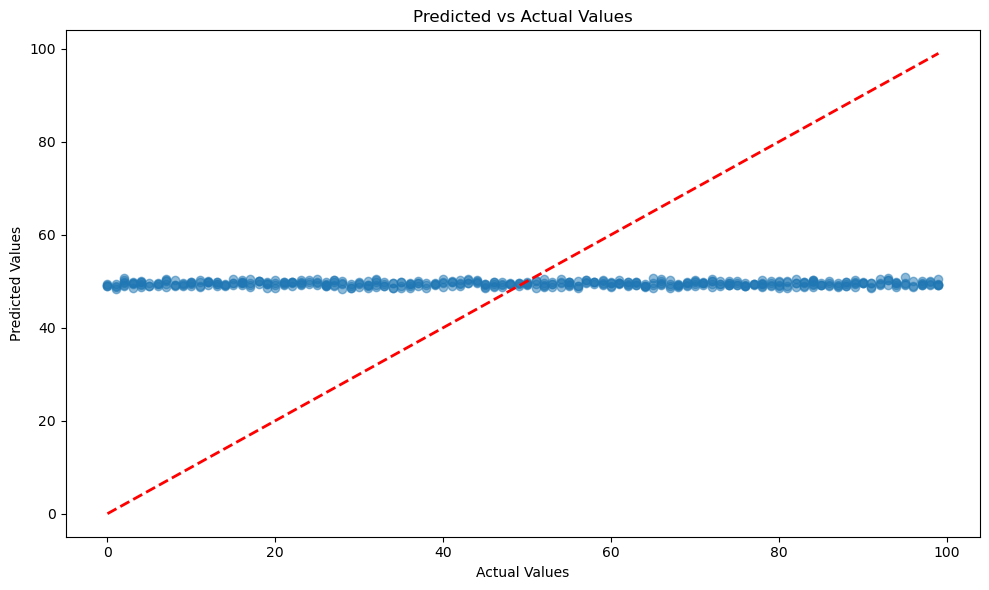

In [64]:
import boto3
import json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

content_type = "text/csv"

def query_endpoint(encoded_tabular_data, endpoint_name):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType=content_type,
        Body=encoded_tabular_data,
    )
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_values = model_predictions["prediction"]
    return np.array(predicted_values)

# split the test data into smaller size of batches to query the endpoint if test data has large size.
batch_size = 1500
predictions = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8"),
        endpoint_name,
    )
    predictions_batch = parse_response(query_response_batch)  # prediction values per batch
    predictions.append(predictions_batch)

predictions = np.concatenate(predictions, axis=0)

# Assuming 'target' is your ground truth values
target = ground_truth_label['Target'].values

# Calculate regression metrics
mse = mean_squared_error(target, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(target, predictions)
r2 = r2_score(target, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Optional: Plot predicted vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(target, predictions, alpha=0.5)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.tight_layout()
plt.show()

In [67]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_applying_machine_learning|sagemaker_lightgbm_distributed_training_dask|sagemaker-lightgbm-distributed-training-dask.ipynb)
